# Lab 10-1: U-NET for Image Segmentation
## Exercise: Semantic Image Segmentation

Load Libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


Prepare Datasets

In [2]:
# tfds works in both Eager and Graph modes
#tf.compat.v1.enable_eager_execution()
(ds_train, ds_test, ds_val), ds_info = tfds.load('oxford_iiit_pet', split=['train', 'test[:50%]', 'test[50%:]'], 
                                                 batch_size=None, shuffle_files=True, # as_supervised=True,
                                                 with_info=True)

print(ds_info.features)
print(ds_info.splits)
print(ds_info.splits['train'].num_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQ46NK6/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQ46NK6/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
{'test': <tfds.core.SplitInfo num_examples=3669>, 'train': <tfds.core.SplitInfo num_examples=3680>}
3680


In [3]:
n_channels = ds_info.features['image'].shape[-1]

classes = ds_info.features['label'].names
species = ds_info.features['species'].names
n_classes = ds_info.features['label'].num_classes

n_train = len(ds_train)
n_test = len(ds_test)
n_val = len(ds_val)

print(n_train,n_test,n_val)

3680 1834 1835


In [7]:
idx = np.random.randint(n_train-1)

# Get one sample of dataset
for sample in ds_train.skip(idx).take(1):
    fname = sample['file_name']
    image = sample['image']
    label = sample['label']
    smask = sample['segmentation_mask']
    specs = sample['species']

list(sample)

['file_name', 'image', 'label', 'segmentation_mask', 'species']

Show a Sample Data

Dog - american_bulldog


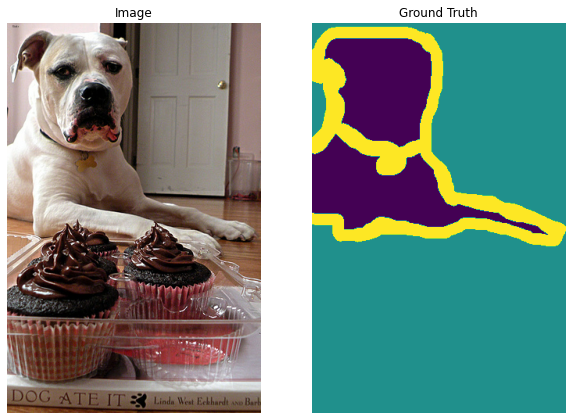

(500, 325, 3)
tf.Tensor([1], shape=(1,), dtype=uint8)
tf.Tensor(1, shape=(), dtype=int64)


In [11]:
print(species[sample['species']]+' - '+classes[sample['label']])

fig, imgw = plt.subplots(1,2,figsize=(10,10))

imgw[0].set_title('Image')
imgw[0].axis('off')
imgw[0].imshow(sample['image'])
imgw[1].set_title('Ground Truth')
imgw[1].axis('off')
imgw[1].imshow(sample['segmentation_mask'][...,0])

plt.show()

print(sample['image'].shape)
print(sample['segmentation_mask'][200][100]) # object: 1, background: 2, outline: 3

Build Input Data Pipelines

With the default settings the weight of a sample is decided by its frequency in the dataset. There are two methods to weight the data, independent of sample frequency:

- Class weights<br>
This is set by passing a dictionary to the class_weight argument to Model.fit(). This dictionary maps class indices to the weight that should be used for samples belonging to this class. For instance, if class "0" is half as represented as class "1" in your data, you could use Model.fit(..., class_weight={0: 1., 1: 0.5}).

- Sample weights<br>
For fine grained control, or if you are not building a classifier, you can use "sample weights". 
    - When training from NumPy data: Pass the sample_weight argument to Model.fit().
    - When training from tf.data or any other sort of iterator: Yield (input_batch, label_batch, sample_weight_batch) tuples.<br>
    A "sample weights" array is an array of numbers that specify how much weight each sample in a batch should have in computing the total loss. It is commonly used in imbalanced classification problems (the idea being to give more weight to rarely-seen classes).

In [46]:
#   tfds_datasets:
#    'file_name': Text(shape=(), dtype=tf.string),
#    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
#    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
#    'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
#    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),

# process augmented data for UNET train
def tfds_augmtd_4_UNET(element):

    image = element['image'] / 255
    image = tf.image.resize(image,[128, 128], method='bilinear', preserve_aspect_ratio=False)
 
    label = element['segmentation_mask'] - 1   # Originally, 1: object, 2: background,  3: outline 
    label = tf.image.resize(label,[128, 128], method='nearest', preserve_aspect_ratio=False)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    return image, label

def gen_sample_weight(image, label):
    # The weights for each class, with the constraint that: sum(class_weights) == 1.0
    # class_weights = {0: 1,  # object
    #                  1: 1,  # background
    #                  2: 2   # outline}
    # sample_weights = the weight matrix to be multiplied to loss matrix.
    #                  the dimension of the sample_weights is same as the label dimension. 

    ### START CODE HERE ###
    
    # class_weight affects outline results
    class_weight = tf.constant([1, 1, 2])  # define weight for each class
    class_weight = class_weight / tf.reduce_sum(class_weight)                   # make the sum of class_weights one

    # Create an image of `sample_weights` by using the label at each pixel 
    # as an index into the `class weights` .

    # By using tf.gather, class_weights can be distributed to the matrix of label size.
    sample_weight = tf.gather(class_weight, tf.cast(label, dtype=tf.int32))           # The label is an integer encoded categorical matrix
    
    ### END CODE HERE ###
    return image, label, sample_weight

In [47]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                            reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

In [48]:
n_batch = 64

# dataset preparation
dataset = ds_train.map(tfds_augmtd_4_UNET, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(gen_sample_weight)
dataset = dataset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

valiset = ds_val.map(tfds_augmtd_4_UNET, num_parallel_calls=tf.data.AUTOTUNE)
valiset = valiset.map(gen_sample_weight)
valiset = valiset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

testset = ds_test.map(tfds_augmtd_4_UNET, num_parallel_calls=tf.data.AUTOTUNE)
testset = testset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

## Build the Model for U-Net with Keras Functional API

Define Premitive Blocks for U-Net: Convolution Block<br>
Block definition for two convolution layers<br>
Use padding in this implementation, although the original U-Net did not use padding.

In [49]:
def ConvBlock(X, channel_size):
   ### START CODE HERE ###

   # first Conv2D then ReLU activation
   X = tf.keras.layers.Conv2D(channel_size, 3, padding='same')(X)        # Convolution
   X = tf.keras.layers.BatchNormalization()(X)        # BatchNorm
   X = tf.keras.layers.Activation('relu')(X)        # ReLU

   # second Conv2D then ReLU activation
   X = tf.keras.layers.Conv2D(channel_size, 3, padding='same')(X)        # Convolution
   X = tf.keras.layers.BatchNormalization()(X)        # BatchNorm
   X = tf.keras.layers.Activation('relu')(X)        # ReLU

   ### END CODE HERE ###
   return X

Build the Entire Model<br>
Be careful with connections between the downsampling netowrk and the upsampling network.

In [50]:
unet_inputs = tf.keras.Input(shape=(128, 128, 3))

### START CODE HERE ###

# encoder: contracting path - downsample
# downsample 1
X1 = ConvBlock(unet_inputs, 64)        # convolution
X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(X1)         # pooling

# downsample 2
X2 = ConvBlock(X, 128)
X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(X2)

# downsample 3
X3 = ConvBlock(X, 256)
X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(X3)

# downsample 4
X4 = ConvBlock(X, 512)
X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(X4)

# bottom layers
X = ConvBlock(X, 1024)

# decoder: expanding path - upsample
# upsample 1
X = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2,2))(X)         # transconvolution
X = tf.keras.layers.Concatenate()([X, X4])         # concatnate
X = ConvBlock(X, 512)         # convolution

# upsample 2
X = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2,2))(X)
X = tf.keras.layers.Concatenate()([X, X3])
X = ConvBlock(X, 256)

# upsample 3
X = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2,2))(X)
X = tf.keras.layers.Concatenate()([X, X2])
X = ConvBlock(X, 128)

# upsample 4
X = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2))(X)
X = tf.keras.layers.Concatenate()([X, X1])
X = ConvBlock(X, 64)

# outputs
unet_outputs = tf.keras.layers.Conv2D(3, 1, padding='same', activation='softmax')(X)    # convolution

### END CODE HERE ###

# Combine Models
UNET = tf.keras.models.Model(inputs=unet_inputs, outputs=unet_outputs)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_151 (Conv2D)            (None, 128, 128, 64  1792        ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_148 (Batch  (None, 128, 128, 64  256        ['conv2d_151[0][0]']             
 Normalization)                 )                                                          

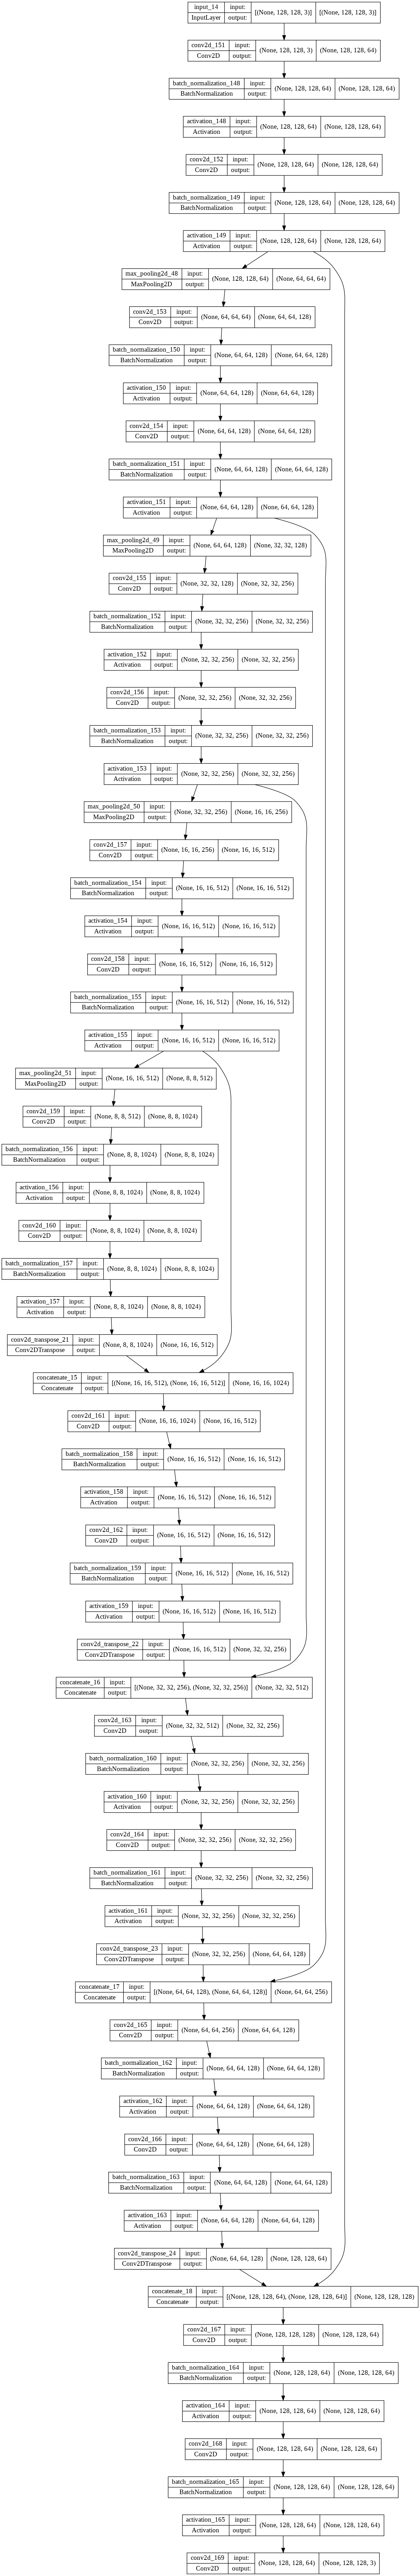

In [51]:
UNET.summary()

with open('UNETsummary.txt','w+') as f:
    UNET.summary(print_fn=lambda x: f.write(x + '\n'))
    f.close()

tf.keras.utils.plot_model(UNET, "UNETsummary.png", show_shapes=True)

### Training The Model

In [52]:
# compile
opt = tf.keras.optimizers.Adam()
UNET.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
from tqdm.keras import TqdmCallback

# Create a callback that saves the model's weights
# checkpoint_filepath = './checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

n_epochs = 10

results = UNET.fit(dataset, epochs=n_epochs, batch_size=n_batch,
                   validation_data=valiset, validation_batch_size=n_batch,
                   verbose=0, callbacks=[TqdmCallback(verbose=2)] )

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

  0%|          | 0.00/58.0 [00:00<?, ?batch/s]

Plot Convergence Graph

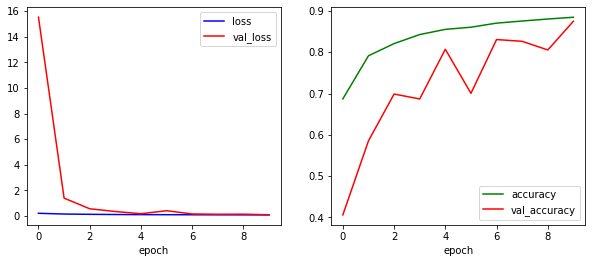

In [54]:
# plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(results.history['loss'], 'b-', label='loss')
plt.plot(results.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results.history['accuracy'], 'g-', label='accuracy')
plt.plot(results.history['val_accuracy'], 'r-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

Evaluate Model Performance

In [55]:
UNET.evaluate(testset)

29/29 [==============================] - 13s 391ms/step - loss: 0.3254 - accuracy: 0.8751


[0.32541924715042114, 0.875074565410614]

### Test Model with a Random Sample


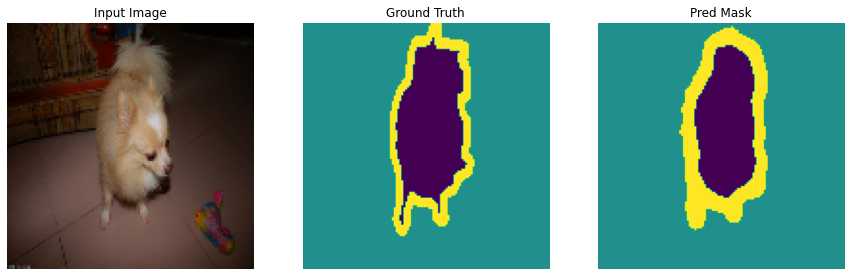

In [56]:
idx = np.random.randint(n_test-1)

for element in ds_test.skip(idx).take(1):
    image, mask = tfds_augmtd_4_UNET(element)
    image = tf.expand_dims(image, axis=0)
    mask = tf.expand_dims(mask, axis=0)

p_mask = UNET.predict(image)
p_mask = tf.argmax(p_mask, axis=-1)
p_mask = p_mask[..., tf.newaxis]

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(image[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth')
plt.imshow(mask[0][...,0])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Pred Mask')
plt.imshow(p_mask[0][...,0])
plt.axis('off')

plt.show()